In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import optuna
import shap
import joblib

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [2]:
# Load datasets
train_df = pd.read_csv("/kaggle/input/parkinson/train.csv")
test_df = pd.read_csv("/kaggle/input/parkinson/test.csv")
val_df = pd.read_csv("/kaggle/input/parkinson/val.csv")

# Define features and target
target_col = "motor_UPDRS"
target_and_related = ["motor_UPDRS", "subject#", "total_UPDRS"]

# Split datasets
X_train = train_df.drop(columns=target_and_related)
y_train = train_df[target_col]

X_test = test_df.drop(columns=target_and_related)
y_test = test_df[target_col]

X_val = val_df.drop(columns=target_and_related)
y_val = val_df[target_col]


In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define Stratified K-Fold cross-validation
n_splits = 5
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
y_binned = discretizer.fit_transform(y_train.values.reshape(-1, 1)).astype(int).flatten()

kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

mae_scores = []
rmse_scores = []
r2_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_binned), 1):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train_fold, y_train_fold)

    # Predict on validation fold
    y_pred_fold = rf_model.predict(X_val_fold)

    # Calculate metrics
    mae = mean_absolute_error(y_val_fold, y_pred_fold)
    rmse = mean_squared_error(y_val_fold, y_pred_fold, squared=False)  # RMSE
    r2 = r2_score(y_val_fold, y_pred_fold)

    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    print(f"Fold {fold}: MAE = {mae:.4f}, RMSE = {rmse:.4f}, R² = {r2:.4f}")

# Print final cross-validation results
print(f"\nMean MAE across folds: {np.mean(mae_scores):.4f}")
print(f"Mean RMSE across folds: {np.mean(rmse_scores):.4f}")
print(f"Mean R² across folds: {np.mean(r2_scores):.4f}")


Fold 1: MAE = 0.8101, RMSE = 1.5090, R² = 0.9661
Fold 2: MAE = 0.8647, RMSE = 1.6045, R² = 0.9606
Fold 3: MAE = 0.8513, RMSE = 1.5526, R² = 0.9630
Fold 4: MAE = 0.8966, RMSE = 1.7402, R² = 0.9550
Fold 5: MAE = 0.7967, RMSE = 1.4917, R² = 0.9663

Mean MAE across folds: 0.8439
Mean RMSE across folds: 1.5796
Mean R² across folds: 0.9622


In [4]:
def objective(trial):
    # Define hyperparameter search space
    n_estimators = trial.suggest_int("n_estimators", 50, 300, step=50)
    max_depth = trial.suggest_int("max_depth", 5, 30, step=5)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)

    # Initialize and train the model
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
    )
    model.fit(X_train, y_train)

    # Predict on validation set
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    return mae

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Print best parameters
print("Best parameters:", study.best_params)


[I 2025-02-22 14:08:49,123] A new study created in memory with name: no-name-1b0e6a7b-f27b-4a7f-a17b-00a172ecf37f
[I 2025-02-22 14:08:58,162] Trial 0 finished with value: 0.8152701166828179 and parameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8152701166828179.
[I 2025-02-22 14:09:05,689] Trial 1 finished with value: 0.7006754008655607 and parameters: {'n_estimators': 150, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.7006754008655607.
[I 2025-02-22 14:09:13,796] Trial 2 finished with value: 1.190372089098597 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.7006754008655607.
[I 2025-02-22 14:09:23,901] Trial 3 finished with value: 1.1993462629613267 and parameters: {'n_estimators': 250, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 1 with value

Best parameters: {'n_estimators': 300, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1}


In [5]:
# Train final model with best hyperparameters
best_params = study.best_params
final_model = RandomForestRegressor(**best_params, random_state=42)
final_model.fit(X_train, y_train)

# Save the trained model
joblib.dump(final_model, "/kaggle/working/random_forest_model.pkl")


['/kaggle/working/random_forest_model.pkl']

          Feature  Importance
0             age    0.658683
2       test_time    0.074922
17            DFA    0.074077
1             sex    0.065222
4     Jitter(Abs)    0.029529
15            HNR    0.012985
16           RPDE    0.011058
18            PPE    0.010436
11   Shimmer:APQ5    0.009703
9     Shimmer(dB)    0.008429
14            NHR    0.007177
12  Shimmer:APQ11    0.006984
8         Shimmer    0.005848
13    Shimmer:DDA    0.005724
10   Shimmer:APQ3    0.005167
6     Jitter:PPQ5    0.004894
7      Jitter:DDP    0.003203
5      Jitter:RAP    0.003080
3       Jitter(%)    0.002878


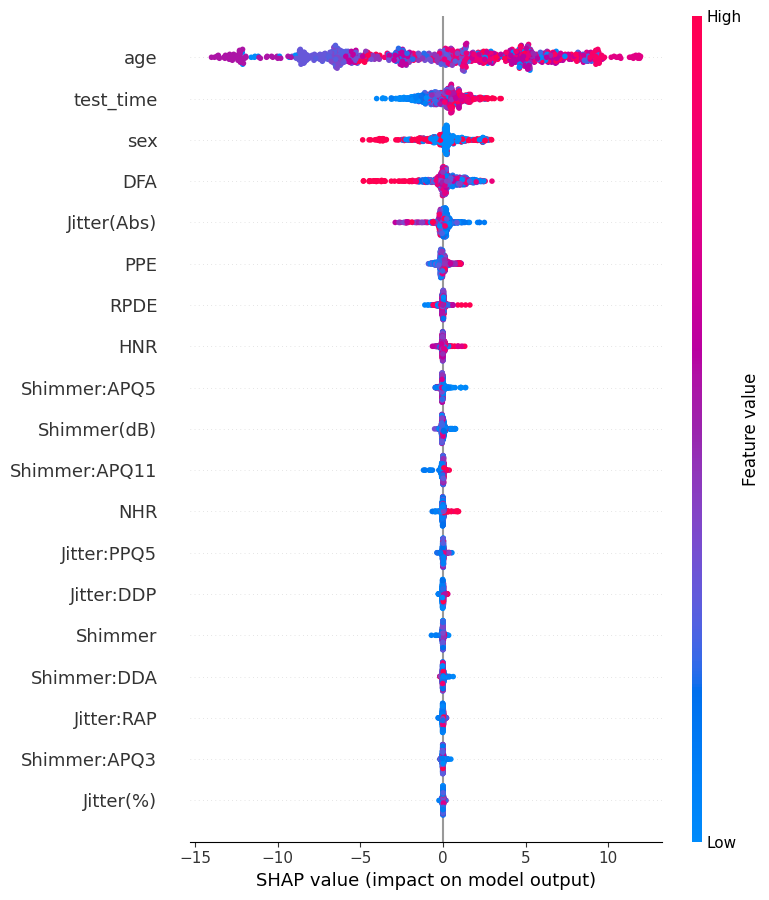

In [6]:
# Compute feature importance
feature_importances = final_model.feature_importances_
feature_importance_df = pd.DataFrame(
    {"Feature": X_train.columns, "Importance": feature_importances}
).sort_values(by="Importance", ascending=False)

print(feature_importance_df)

# SHAP analysis
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_val)

# Summary plot
shap.summary_plot(shap_values, X_val)


In [7]:
# Load saved model
loaded_model = joblib.load("random_forest_model.pkl")

# Predict on test data
y_pred_test = loaded_model.predict(X_test)

# Evaluate
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)  # RMSE
r2_test = r2_score(y_test, y_pred_test)

# Print evaluation metrics
print(f"Test MAE: {mae_test:.4f}")
print(f"Test MSE: {mse_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")  # Added RMSE
print(f"Test R2 Score: {r2_test:.4f}")


Test MAE: 0.7083
Test MSE: 2.1877
Test RMSE: 1.4791
Test R2 Score: 0.9670
